In [1]:
import sys
import os
import torch
import yaml

#print(sys.path)
#sys.path.insert(0,'/home/srikanth/code/vilbert/vilbert-multi-task')
#sys.path.insert(1,'/home/srikanth/code/vilbert/vilbert-multi-task')
#print(sys.path)

from easydict import EasyDict as edict
from pytorch_transformers.tokenization_bert import BertTokenizer
from vilbert.datasets import ConceptCapLoaderTrain, ConceptCapLoaderVal
from vilbert.vilbert import VILBertForVLTasks, BertConfig, BertForMultiModalPreTraining
from vilbert.task_utils import LoadDatasetEval

import numpy as np
import matplotlib.pyplot as plt
import PIL

from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.layers import nms
from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.utils.model_serialization import load_state_dict

from PIL import Image
import cv2
import argparse
import glob
from types import SimpleNamespace
import pdb

%matplotlib inline  

In [2]:
class FeatureExtractor:
    MAX_SIZE = 1333
    MIN_SIZE = 800

    def __init__(self):
        self.args = self.get_parser()
        self.detection_model = self._build_detection_model()

    def get_parser(self):        
        parser = SimpleNamespace(model_file= 'save/resnext_models/model_final.pth',
                                #model_file= 'save/resnext_models/detectron_model.pth',
                                #config_file='save/resnext_models/e2e_faster_rcnn_X-152-32x8d-FPN_1x_MLP_2048_FPN_512_train.yaml',
                                config_file = 'save/resnext_models/modified_for_conversion_e2e_faster_rcnn_X-101-64x4d-FPN_1x_MLP_2048_FPN_512.yaml',
                                batch_size=1,
                                num_features=100,
                                feature_name="fc6",
                                confidence_threshold=0,
                                background=False,
                                partition=0)
        return parser
    
    def _build_detection_model(self):
        cfg.merge_from_file(self.args.config_file)
        cfg.freeze()

        model = build_detection_model(cfg)
        checkpoint = torch.load(self.args.model_file, map_location=torch.device("cpu"))

        load_state_dict(model, checkpoint.pop("model"))

        model.to("cuda")
        model.eval()
        return model

    def _image_transform(self, path):
        img = Image.open(path)
        im = np.array(img).astype(np.float32)
        # IndexError: too many indices for array, grayscale images
        if len(im.shape) < 3:
            im = np.repeat(im[:, :, np.newaxis], 3, axis=2)
        im = im[:, :, ::-1]
        im -= np.array([102.9801, 115.9465, 122.7717])
        im_shape = im.shape
        im_height = im_shape[0]
        im_width = im_shape[1]
        im_size_min = np.min(im_shape[0:2])
        im_size_max = np.max(im_shape[0:2])

        # Scale based on minimum size
        im_scale = self.MIN_SIZE / im_size_min

        # Prevent the biggest axis from being more than max_size
        # If bigger, scale it down
        if np.round(im_scale * im_size_max) > self.MAX_SIZE:
            im_scale = self.MAX_SIZE / im_size_max

        im = cv2.resize(
            im, None, None, fx=im_scale, fy=im_scale, interpolation=cv2.INTER_LINEAR
        )
        img = torch.from_numpy(im).permute(2, 0, 1)

        im_info = {"width": im_width, "height": im_height}

        return img, im_scale, im_info

    def _process_feature_extraction(
        self, output, im_scales, im_infos, feature_name="fc6", conf_thresh=0
    ):
        batch_size = len(output[0]["proposals"])
        n_boxes_per_image = [len(boxes) for boxes in output[0]["proposals"]]
        score_list = output[0]["scores"].split(n_boxes_per_image)
        score_list = [torch.nn.functional.softmax(x, -1) for x in score_list]
        feats = output[0][feature_name].split(n_boxes_per_image)
        cur_device = score_list[0].device

        feat_list = []
        info_list = []

        for i in range(batch_size):
            dets = output[0]["proposals"][i].bbox / im_scales[i]
            scores = score_list[i]
            max_conf = torch.zeros((scores.shape[0])).to(cur_device)
            conf_thresh_tensor = torch.full_like(max_conf, conf_thresh)
            start_index = 1
            # Column 0 of the scores matrix is for the background class
            if self.args.background:
                start_index = 0
            for cls_ind in range(start_index, scores.shape[1]):
                cls_scores = scores[:, cls_ind]
                keep = nms(dets, cls_scores, 0.5)
                max_conf[keep] = torch.where(
                    # Better than max one till now and minimally greater than conf_thresh
                    (cls_scores[keep] > max_conf[keep])
                    & (cls_scores[keep] > conf_thresh_tensor[keep]),
                    cls_scores[keep],
                    max_conf[keep],
                )

            sorted_scores, sorted_indices = torch.sort(max_conf, descending=True)
            num_boxes = (sorted_scores[: self.args.num_features] != 0).sum()
            keep_boxes = sorted_indices[: self.args.num_features]
            feat_list.append(feats[i][keep_boxes])
            bbox = output[0]["proposals"][i][keep_boxes].bbox / im_scales[i]
            # Predict the class label using the scores
            objects = torch.argmax(scores[keep_boxes][start_index:], dim=1)
            cls_prob = torch.max(scores[keep_boxes][start_index:], dim=1)

            info_list.append(
                {
                    "bbox": bbox.cpu().numpy(),
                    "num_boxes": num_boxes.item(),
                    "objects": objects.cpu().numpy(),
                    "image_width": im_infos[i]["width"],
                    "image_height": im_infos[i]["height"],
                    "cls_prob": scores[keep_boxes].cpu().numpy(),
                }
            )

        return feat_list, info_list

    def get_detectron_features(self, image_paths):
        img_tensor, im_scales, im_infos = [], [], []

        for image_path in image_paths:
            im, im_scale, im_info = self._image_transform(image_path)
            img_tensor.append(im)
            im_scales.append(im_scale)
            im_infos.append(im_info)

        # Image dimensions should be divisible by 32, to allow convolutions
        # in detector to work
        current_img_list = to_image_list(img_tensor, size_divisible=32)
        current_img_list = current_img_list.to("cuda")

        with torch.no_grad():
            output = self.detection_model(current_img_list)

        feat_list = self._process_feature_extraction(
            output,
            im_scales,
            im_infos,
            self.args.feature_name,
            self.args.confidence_threshold,
        )

        return feat_list

    def _chunks(self, array, chunk_size):
        for i in range(0, len(array), chunk_size):
            yield array[i : i + chunk_size]

    def _save_feature(self, file_name, feature, info):
        file_base_name = os.path.basename(file_name)
        file_base_name = file_base_name.split(".")[0]
        info["image_id"] = file_base_name
        info["features"] = feature.cpu().numpy()
        file_base_name = file_base_name + ".npy"

        np.save(os.path.join(self.args.output_folder, file_base_name), info)

    def extract_features(self, image_path):

        features, infos = self.get_detectron_features([image_path])

        return features, infos


In [3]:
def tokenize_batch(batch):
    return [tokenizer.convert_tokens_to_ids(sent) for sent in batch]

def untokenize_batch(batch):
    return [tokenizer.convert_ids_to_tokens(sent) for sent in batch]

def detokenize(sent):
    """ Roughly detokenizes (mainly undoes wordpiece) """
    new_sent = []
    for i, tok in enumerate(sent):
        if tok.startswith("##"):
            new_sent[len(new_sent) - 1] = new_sent[len(new_sent) - 1] + tok[2:]
        else:
            new_sent.append(tok)
    return new_sent

def printer(sent, should_detokenize=True):
    if should_detokenize:
        sent = detokenize(sent)[1:-1]
    print(" ".join(sent))


# write arbitary string for given sentense. 
import _pickle as cPickle

In [4]:
def prediction(question, features, spatials, segment_ids, input_mask, image_mask, co_attention_mask, task_tokens, ):

    vil_prediction, vil_prediction_gqa, vil_logit, vil_binary_prediction, vil_tri_prediction, vision_prediction, vision_logit, linguisic_prediction, linguisic_logit, attn_data_list = model(
        question, features, spatials, segment_ids, input_mask, image_mask, co_attention_mask, task_tokens, output_all_attention_masks=True
    )
    
    height, width = img.shape[0], img.shape[1]

    logits = torch.max(vil_prediction, 1)[1].data  # argmax
    # Load VQA label to answers:
    label2ans_path = os.path.join('save', "VQA" ,"cache", "trainval_label2ans.pkl")
    vqa_label2ans = cPickle.load(open(label2ans_path, "rb"))
    answer = vqa_label2ans[logits[0].item()]
    print("VQA: " + answer)

    # Load GQA label to answers:
    label2ans_path = os.path.join('save', "gqa" ,"cache", "trainval_label2ans.pkl")

    logtis_gqa = torch.max(vil_prediction_gqa, 1)[1].data
    gqa_label2ans = cPickle.load(open(label2ans_path, "rb"))
    answer = gqa_label2ans[logtis_gqa[0].item()]
    print("GQA: " + answer)

    # vil_binary_prediction NLVR2, 0: False 1: True Task 12
    logtis_binary = torch.max(vil_binary_prediction, 1)[1].data
    print("NLVR: " + str(logtis_binary.item()))

    # vil_entaliment:  
    label_map = {0:"contradiction", 1:"neutral", 2:"entailment"}
    logtis_tri = torch.max(vil_tri_prediction, 1)[1].data
    print("Entaliment: " + str(label_map[logtis_tri.item()]))

    # vil_logit: 
    logits_vil = vil_logit[0].item()
    print("ViL_logit: %f" %logits_vil)

    # grounding: 
    logits_vision = torch.max(vision_logit, 1)[1].data
    grounding_val, grounding_idx = torch.sort(vision_logit.view(-1), 0, True)

    examples_per_row = 5
    ncols = examples_per_row 
    nrows = 1
    figsize = [12, ncols*20]     # figure size, inches
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    for i, axi in enumerate(ax.flat):
        idx = grounding_idx[i]
        val = grounding_val[i]
        box = spatials[0][idx][:4].tolist()
        y1 = int(box[1] * height)
        y2 = int(box[3] * height)
        x1 = int(box[0] * width)
        x2 = int(box[2] * width)
        patch = img[y1:y2,x1:x2]
        axi.imshow(patch)
        axi.axis('off')
        axi.set_title(str(i) + ": " + str(val.item()))

    plt.axis('off')
    plt.tight_layout(True)
    plt.show()  

In [5]:
def custom_prediction(query, task, features, infos):

    tokens = tokenizer.encode(query)
    tokens = tokenizer.add_special_tokens_single_sentence(tokens)

    segment_ids = [0] * len(tokens)
    input_mask = [1] * len(tokens)

    max_length = 37
    if len(tokens) < max_length:
        # Note here we pad in front of the sentence
        padding = [0] * (max_length - len(tokens))
        tokens = tokens + padding
        input_mask += padding
        segment_ids += padding

    text = torch.from_numpy(np.array(tokens)).cuda().unsqueeze(0)
    input_mask = torch.from_numpy(np.array(input_mask)).cuda().unsqueeze(0)
    segment_ids = torch.from_numpy(np.array(segment_ids)).cuda().unsqueeze(0)
    task = torch.from_numpy(np.array(task)).cuda().unsqueeze(0)

    num_image = len(infos)

    feature_list = []
    image_location_list = []
    image_mask_list = []
    for i in range(num_image):
        image_w = infos[i]['image_width']
        image_h = infos[i]['image_height']
        feature = features[i]
        num_boxes = feature.shape[0]

        g_feat = torch.sum(feature, dim=0) / num_boxes
        num_boxes = num_boxes + 1
        feature = torch.cat([g_feat.view(1,-1), feature], dim=0)
        boxes = infos[i]['bbox']
        image_location = np.zeros((boxes.shape[0], 5), dtype=np.float32)
        image_location[:,:4] = boxes
        image_location[:,4] = (image_location[:,3] - image_location[:,1]) * (image_location[:,2] - image_location[:,0]) / (float(image_w) * float(image_h))
        image_location[:,0] = image_location[:,0] / float(image_w)
        image_location[:,1] = image_location[:,1] / float(image_h)
        image_location[:,2] = image_location[:,2] / float(image_w)
        image_location[:,3] = image_location[:,3] / float(image_h)
        g_location = np.array([0,0,1,1,1])
        image_location = np.concatenate([np.expand_dims(g_location, axis=0), image_location], axis=0)
        image_mask = [1] * (int(num_boxes))

        feature_list.append(feature)
        image_location_list.append(torch.tensor(image_location))
        image_mask_list.append(torch.tensor(image_mask))

    features = torch.stack(feature_list, dim=0).float().cuda()
    spatials = torch.stack(image_location_list, dim=0).float().cuda()
    image_mask = torch.stack(image_mask_list, dim=0).byte().cuda()
    co_attention_mask = torch.zeros((num_image, num_boxes, max_length)).cuda()

    prediction(text, features, spatials, segment_ids, input_mask, image_mask, co_attention_mask, task)

In [6]:

# =============================
# ViLBERT part
# =============================
feature_extractor = FeatureExtractor()

args = SimpleNamespace(from_pretrained= "save/multitask_model/pytorch_model_9.bin",
                       bert_model="bert-base-uncased",
                       config_file="config/bert_base_6layer_6conect.json",
                       max_seq_length=101,
                       train_batch_size=1,
                       do_lower_case=True,
                       predict_feature=False,
                       seed=42,
                       num_workers=0,
                       baseline=False,
                       img_weight=1,
                       distributed=False,
                       objective=1,
                       visual_target=0,
                       dynamic_attention=False,
                       task_specific_tokens=True,
                       tasks='1',
                       save_name='',
                       in_memory=False,
                       batch_size=1,
                       local_rank=-1,
                       split='mteval',
                       clean_train_sets=True
                      )

config = BertConfig.from_json_file(args.config_file)
with open('./vilbert_tasks.yml', 'r') as f:
    task_cfg = edict(yaml.safe_load(f))

task_names = []
for i, task_id in enumerate(args.tasks.split('-')):
    task = 'TASK' + task_id
    name = task_cfg[task]['name']
    task_names.append(name)

timeStamp = args.from_pretrained.split('/')[-1] + '-' + args.save_name
config = BertConfig.from_json_file(args.config_file)
default_gpu=True

if args.predict_feature:
    config.v_target_size = 2048
    config.predict_feature = True
else:
    config.v_target_size = 1601
    config.predict_feature = False

if args.task_specific_tokens:
    config.task_specific_tokens = True    

if args.dynamic_attention:
    config.dynamic_attention = True

config.visualization = True
num_labels = 3129

if args.baseline:
    model = BaseBertForVLTasks.from_pretrained(
        args.from_pretrained, config=config, num_labels=num_labels, default_gpu=default_gpu
        )
else:
    model = VILBertForVLTasks.from_pretrained(
        args.from_pretrained, config=config, num_labels=num_labels, default_gpu=default_gpu
        )
    
model.eval()
cuda = torch.cuda.is_available()
if cuda: model = model.cuda(0)
tokenizer = BertTokenizer.from_pretrained(
    args.bert_model, do_lower_case=args.do_lower_case
)


07/18/2022 20:49:50 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer1.0.bn1.bias                  loaded from layer1.0.bn1.bias            of shape (256,)
07/18/2022 20:49:50 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer1.0.bn1.weight                loaded from layer1.0.bn1.weight          of shape (256,)
07/18/2022 20:49:50 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer1.0.bn2.bias                  loaded from layer1.0.bn2.bias            of shape (256,)
07/18/2022 20:49:50 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer1.0.bn2.weight                loaded from layer1.0.bn2.weight          of shape (256,)
07/18/2022 20:49:50 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer1.0.bn3.bias                  loaded from layer1.0.bn3.bias            of shape (256,)
07/18/2022 20:49:50 - INFO - maskrcnn_benchmark.utils.model_serialization -   ba

07/18/2022 20:49:50 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.1.bn2.bias                  loaded from layer2.1.bn2.bias            of shape (512,)
07/18/2022 20:49:50 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.1.bn2.weight                loaded from layer2.1.bn2.weight          of shape (512,)
07/18/2022 20:49:50 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.1.bn3.bias                  loaded from layer2.1.bn3.bias            of shape (512,)
07/18/2022 20:49:50 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.1.bn3.weight                loaded from layer2.1.bn3.weight          of shape (512,)
07/18/2022 20:49:50 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.1.conv1.weight              loaded from layer2.1.conv1.weight        of shape (512, 512, 1, 1)
07/18/2022 20:49:50 - INFO - maskrcnn_benchmark.utils.model_serializat

07/18/2022 20:49:50 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.1.conv2.weight              loaded from layer3.1.conv2.weight        of shape (1024, 16, 3, 3)
07/18/2022 20:49:50 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.1.conv3.weight              loaded from layer3.1.conv3.weight        of shape (1024, 1024, 1, 1)
07/18/2022 20:49:50 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.10.bn1.bias                 loaded from layer3.10.bn1.bias           of shape (1024,)
07/18/2022 20:49:50 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.10.bn1.weight               loaded from layer3.10.bn1.weight         of shape (1024,)
07/18/2022 20:49:50 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.10.bn2.bias                 loaded from layer3.10.bn2.bias           of shape (1024,)
07/18/2022 20:49:50 - INFO - maskrcnn_benchmark.utils.m

07/18/2022 20:49:50 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.14.conv1.weight             loaded from layer3.14.conv1.weight       of shape (1024, 1024, 1, 1)
07/18/2022 20:49:50 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.14.conv2.weight             loaded from layer3.14.conv2.weight       of shape (1024, 16, 3, 3)
07/18/2022 20:49:50 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.14.conv3.weight             loaded from layer3.14.conv3.weight       of shape (1024, 1024, 1, 1)
07/18/2022 20:49:50 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.15.bn1.bias                 loaded from layer3.15.bn1.bias           of shape (1024,)
07/18/2022 20:49:50 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.15.bn1.weight               loaded from layer3.15.bn1.weight         of shape (1024,)
07/18/2022 20:49:50 - INFO - maskrcnn_benchm

07/18/2022 20:49:51 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.19.bn3.weight               loaded from layer3.19.bn3.weight         of shape (1024,)
07/18/2022 20:49:51 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.19.conv1.weight             loaded from layer3.19.conv1.weight       of shape (1024, 1024, 1, 1)
07/18/2022 20:49:51 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.19.conv2.weight             loaded from layer3.19.conv2.weight       of shape (1024, 16, 3, 3)
07/18/2022 20:49:51 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.19.conv3.weight             loaded from layer3.19.conv3.weight       of shape (1024, 1024, 1, 1)
07/18/2022 20:49:51 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.2.bn1.bias                  loaded from layer3.2.bn1.bias            of shape (1024,)
07/18/2022 20:49:51 - INFO - maskrcnn_benchm

07/18/2022 20:49:51 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.3.bn3.bias                  loaded from layer3.3.bn3.bias            of shape (1024,)
07/18/2022 20:49:51 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.3.bn3.weight                loaded from layer3.3.bn3.weight          of shape (1024,)
07/18/2022 20:49:51 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.3.conv1.weight              loaded from layer3.3.conv1.weight        of shape (1024, 1024, 1, 1)
07/18/2022 20:49:51 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.3.conv2.weight              loaded from layer3.3.conv2.weight        of shape (1024, 16, 3, 3)
07/18/2022 20:49:51 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.3.conv3.weight              loaded from layer3.3.conv3.weight        of shape (1024, 1024, 1, 1)
07/18/2022 20:49:51 - INFO - maskrcnn_benchm

07/18/2022 20:49:51 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.8.bn2.weight                loaded from layer3.8.bn2.weight          of shape (1024,)
07/18/2022 20:49:51 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.8.bn3.bias                  loaded from layer3.8.bn3.bias            of shape (1024,)
07/18/2022 20:49:51 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.8.bn3.weight                loaded from layer3.8.bn3.weight          of shape (1024,)
07/18/2022 20:49:51 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.8.conv1.weight              loaded from layer3.8.conv1.weight        of shape (1024, 1024, 1, 1)
07/18/2022 20:49:51 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.8.conv2.weight              loaded from layer3.8.conv2.weight        of shape (1024, 16, 3, 3)
07/18/2022 20:49:51 - INFO - maskrcnn_benchmark.utils.m

07/18/2022 20:49:51 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer4.2.conv3.weight              loaded from layer4.2.conv3.weight        of shape (2048, 2048, 1, 1)
07/18/2022 20:49:51 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.stem.bn1.bias                      loaded from bn1.bias                     of shape (64,)
07/18/2022 20:49:51 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.stem.bn1.weight                    loaded from bn1.weight                   of shape (64,)
07/18/2022 20:49:51 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.stem.conv1.weight                  loaded from conv1.weight                 of shape (64, 3, 7, 7)
07/18/2022 20:49:51 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.fpn.fpn_inner1.bias                     loaded from fpn_inner1.bias              of shape (512,)
07/18/2022 20:49:51 - INFO - maskrcnn_benchmark.utils.model_ser

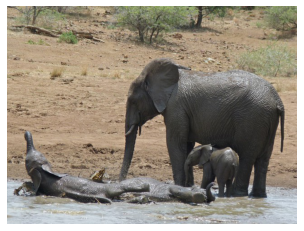

VQA: nothing
GQA: pond
NLVR: 1
Entaliment: contradiction
ViL_logit: -4.206152


/home/srikanth/anaconda3/envs/vilbert-mt/lib/python3.6/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


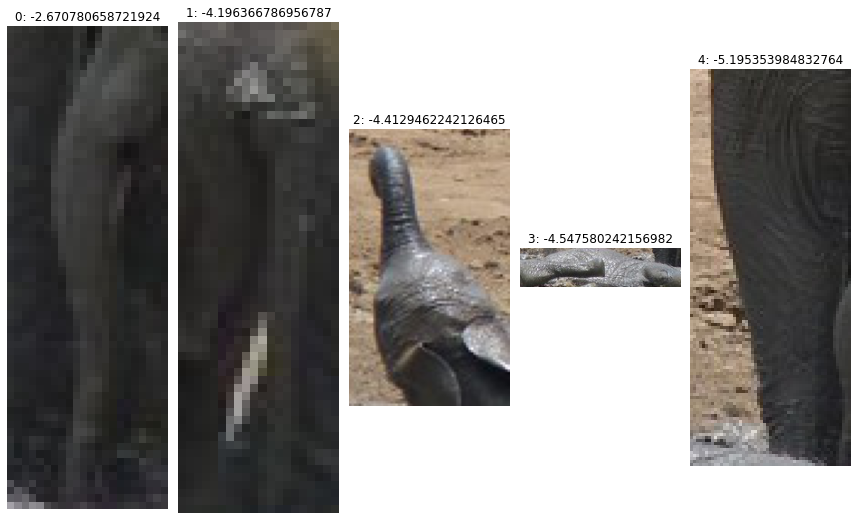

In [11]:
# 1: VQA, 2: GenomeQA, 4: Visual7w, 7: Retrieval COCO, 8: Retrieval Flickr30k 
# 9: refcoco, 10: refcoco+ 11: refcocog, 12: NLVR2, 13: VisualEntailment, 15: GQA, 16: GuessWhat, 


image_path = 'demo/1.jpg'
features, infos = feature_extractor.extract_features(image_path)

img = PIL.Image.open(image_path).convert('RGB')
img = torch.tensor(np.array(img))

plt.axis('off')
plt.imshow(img)
plt.show()
    
query = "swimming elephant"
task = [9]
custom_prediction(query, task, features, infos)

In [ ]:
# FileNotFoundError: [Errno 2] No such file or directory: 'FAST_RCNN_MLP_DIM2048_FPN_DIM512.pkl'
## https://github.com/gabegrand/pythia-1/blob/master/data_prep/data_preprocess.md
## https://github.com/facebookresearch/mmf/issues/30
# !wget https://dl.fbaipublicfiles.com/pythia/detectron_model/FAST_RCNN_MLP_DIM2048_FPN_DIM512.pkl
#!wget https://dl.fbaipublicfiles.com/vilbert-multi-task/multi_task_model.bin

In [ ]:
#!mkdir save
#!mkdir save/multitask_model
#%mv multi_task_model.bin save/multitask_model/pytorch_model_9.bin

In [ ]:
#Creating model.path using the code from https://gitlab.com/vedanuj/vqa-maskrcnn-benchmark
#https://gitlab.com/vedanuj/vqa-maskrcnn-benchmark/-/blob/master/tools/c2_to_pt.py
import torch as t

from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.utils.c2_model_loading import load_c2_format

path = "/home/srikanth/code/vilbert/vilbert-multi-task/save/resnext_models/FAST_RCNN_MLP_DIM2048_FPN_DIM512.pkl"
config_name = 'modified_for_conversion_e2e_faster_rcnn_X-101-64x4d-FPN_1x_MLP_2048_FPN_512.yaml'
#base_path = '/private/home/meetshah/detectron/vmb/configs/visual_genome_vqa/c2/'
base_path = '/home/srikanth/code/vilbert/vilbert-multi-task/save/resnext_models/'

cfg.merge_from_file(base_path + config_name)

_d = load_c2_format(cfg, path)
newdict = _d
t.save(newdict, "model_final.pth")
